# Dogs vs Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

print(tf.__version__)
print(tf.executing_eagerly())

2.4.0
True


## Функции загрузки данных

In [4]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=64):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [25]:
train_files[0]

'data/train\\cat.6700.jpg'

In [24]:
test_files[0]

'data/test\\4919.jpg'

## Визуализируем примеры для обучения

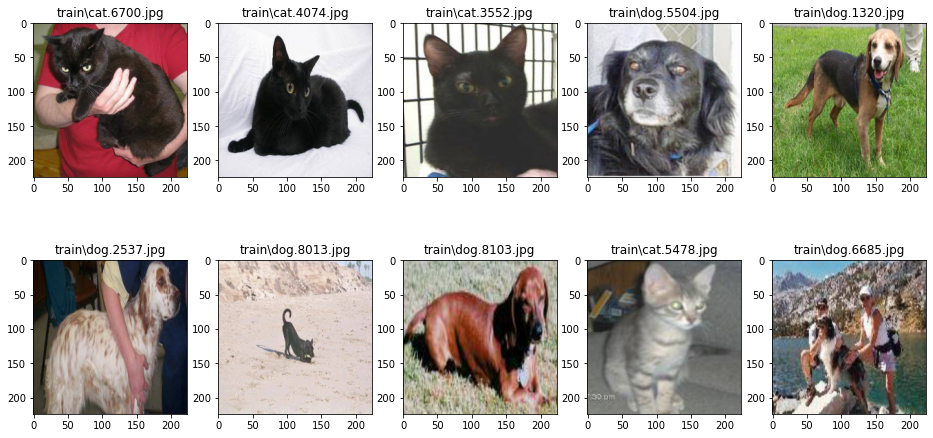

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img);

In [27]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = vgg16.VGG16(weights='imagenet',
                         include_top = False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [9]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Добавляем полносвязный слой

In [28]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False


x = base_model.layers[-5].output

x = tf.keras.layers.Flatten()(x)

# x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.BatchNormalization()(x)


x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation = 'sigmoid',  # функция активации  
                          kernel_regularizer = tf.keras.regularizers.l1(1e-4))(x)

# x = tf.keras.layers.Dropout(0.3)(x)

In [29]:
model = tf.keras.Model(inputs = base_model.input, outputs = x, name = 'dogs_vs_cats')

## Выводим архитектуру модели

In [30]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [24]:
# chek count params
14*14*512+1

100353

## Компилируем модель и запускаем обучение

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-8), 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [34]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss',
                              patience=5,
                              min_delta=1e-7,
                              verbose=2,
                              factor=.5,
                              min_lr=1e-10,
                              mode='auto')

early_stopping = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              min_delta=1e-7,
                              patience=2,
                              verbose=2,
                              mode='auto',
                              restore_best_weights=False)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                              '20210915_model_VGG16_custom.h5',
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True,
                              mode='min')

In [35]:
shuffle(train_files)
validation_data = next(fit_generator(train_files))
train_data = fit_generator(train_files)

In [36]:
hist = model.fit(train_data,
                 batch_size = 128,
                 steps_per_epoch = 100,
                 epochs = 100,
                 validation_data = validation_data,
                 callbacks = [model_checkpoint, reduce_lr, early_stopping])

Epoch 1/100
100/100 [==============================] - 630s 6s/step - loss: 0.8017 - accuracy: 0.5918 - val_loss: 0.4961 - val_accuracy: 0.7969

Epoch 00001: val_loss improved from inf to 0.49613, saving model to 20210915_model_VGG16_custom.h5
Epoch 2/100
100/100 [==============================] - 636s 6s/step - loss: 0.4695 - accuracy: 0.8014 - val_loss: 0.3552 - val_accuracy: 0.8438

Epoch 00002: val_loss improved from 0.49613 to 0.35521, saving model to 20210915_model_VGG16_custom.h5
Epoch 3/100
100/100 [==============================] - 638s 6s/step - loss: 0.4043 - accuracy: 0.8340 - val_loss: 0.2954 - val_accuracy: 0.9219

Epoch 00003: val_loss improved from 0.35521 to 0.29537, saving model to 20210915_model_VGG16_custom.h5
Epoch 4/100
100/100 [==============================] - 637s 6s/step - loss: 0.3563 - accuracy: 0.8647 - val_loss: 0.2648 - val_accuracy: 0.9375

Epoch 00004: val_loss improved from 0.29537 to 0.26476, saving model to 20210915_model_VGG16_custom.h5
Epoch 5/100


In [37]:
model.save('20210915_cats-dogs-vgg16.hdf5')

## Предсказания на проверочной выборке

In [38]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

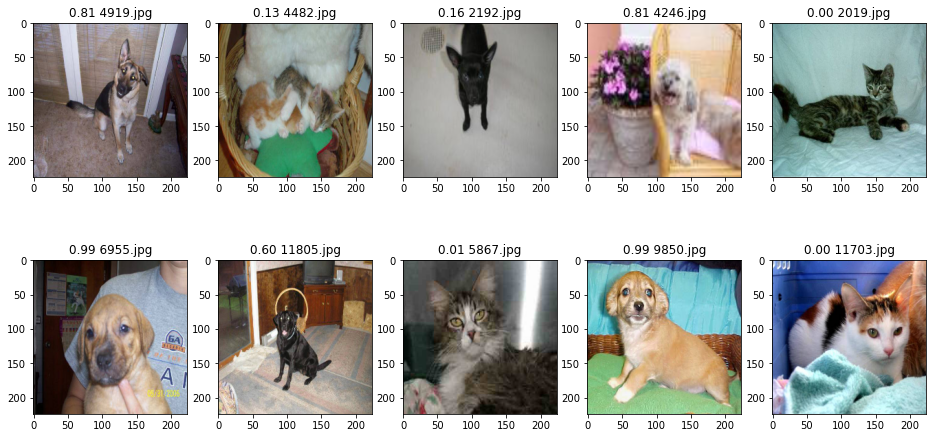

In [39]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Готовим данные для отправки

In [40]:
import re

with open('submit_cats_dogs_8.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [48]:
# LogLoss = 0.17622   I have done it)))   

In [41]:
from IPython.display import Image

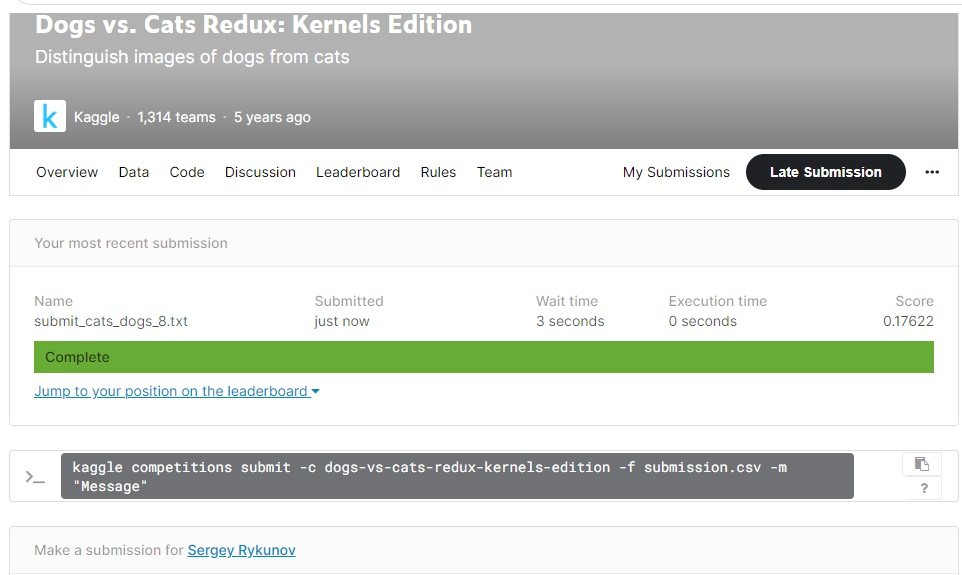

In [42]:
Image("2021_09_15_23_42_18_Kaggle_Dogs_vs_Cats.jpg")